# Time sequences

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/yggdrasil-decision-forests/blob/main/documentation/public/docs/tutorial/time_sequences.ipynb)

## Setup

In [ ]:
# pip install ydf temporian -U

In [8]:
import ydf
import temporian as tp

import pandas as pd
import datetime
import os

## What are time sequences?

**Time-sequences** or **Event-sequences** are time-stamped events with feature-data that are not uniformly sampled. There are many examples for this type of data: banking transaction logs, sales logs, network logs, patient measures, treatment logs and many others. Decision Forests are well-suited for handling event sequences because the output of preprocessing event sequences is tabular and can be sparse and noisy.

YDF models benefit greatly from feature preprocessing when working with temporal data. Basic operations can be handled with generic data processing tools like Pandas. For more complex use cases, temporal feature preprocessing tools are very helpful. This tutorial demonstrates how to integrate YDF with the [Temporian](https://temporian.readthedocs.io/) data preprocessing library.

In this notebook, our goal is to determine if transactions from the [Reproducible Machine Learning for Credit Card Fraud Detection](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html) dataset are fraudulent. Each transaction is an event with an amount, client ID, and terminal ID. Our model will consider the transaction features as well as related transactions (e.g., transactions from the same client and transactions from the same terminal). For that, we will pre-process the event data such that the YDF model can detect frauds.

**Note:** This tutorial is a simplified adaptation of the [Detecting payment card fraud with Temporian and TensorFlow Decision Forests tutorial](https://temporian.readthedocs.io/en/latest/tutorials/bank_fraud_detection_with_tfdf/).

**Note2:** Yggdrasil Decision Forests and Temporian share part of their development team.

## Download dataset

Transaction data is available in CSV format, with one file for each day between April 1, 2018, and September 30, 2018. We use transactions from April 1, 2018, to August 31, 2018 (inclusive) for training, and transactions from September 1, 2018, to September 30, 2018, for evaluation.

In [46]:
start_date = datetime.date(2018, 4, 1)
end_date = datetime.date(2018, 9, 30)
train_test_split = datetime.datetime(2018, 9, 1)

# List the input csv files
filenames = []
while start_date <= end_date:
    filenames.append(f"{start_date}.pkl")
    start_date += datetime.timedelta(days=1)
print(f"{len(filenames)} dates")

# Download and load files
print("Loading files (this step can take a minute)")
def load_date(idx_and_filename):
    if (idx_and_filename[0]%10) == 0:
        print(f"[{idx_and_filename[0]}/{len(filenames)}]", end="", flush=True)
    return pd.read_pickle(f"https://github.com/Fraud-Detection-Handbook/simulated-data-raw/raw/main/data/{idx_and_filename[1]}")
transactions_pd = pd.concat(map(load_date, enumerate(filenames)))
print("Done!")

print(f"Found {len(transactions_pd)} transactions")

183 dates
Loading files (this step can take a minute)
[0/183][10/183][20/183][30/183][40/183][50/183][60/183][70/183][80/183][90/183][100/183][110/183][120/183][130/183][140/183][150/183][160/183][170/183][180/183]Done!
Found 1754155 transactions


In [57]:
transactions_pd

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0
...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0


`TX_FRAUD` indicates if a transaction is a fraud. This is the label.


## Prepare data

The data we have is currently stored in a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). We want to convert it to a Temporian EventSet so that we can apply preprocessing.

In [58]:
transactions_es = tp.from_pandas(
    transactions_pd[["TX_DATETIME", "CUSTOMER_ID", "TERMINAL_ID",
                     "TX_AMOUNT", "TX_FRAUD"]],
    timestamps="TX_DATETIME")

transactions_es

timestamp,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
2018-04-01 00:00:31+00:00,596,3156,57.16,0
2018-04-01 00:02:10+00:00,4961,3412,81.51,0
2018-04-01 00:07:56+00:00,2,1365,146,0
2018-04-01 00:09:29+00:00,4128,8737,64.49,0
2018-04-01 00:10:34+00:00,927,9906,50.99,0
…,…,…,…,…


Let's plot the transactions of `CUSTOMER_ID=3774`. We can see a few frauds.

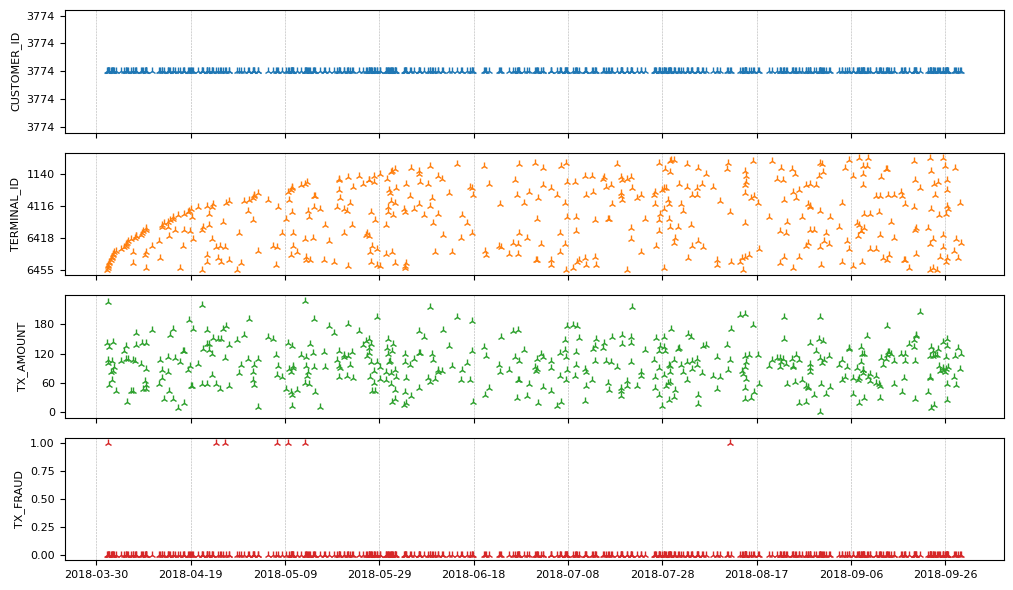

In [59]:
transactions_es.filter(tp.equal(transactions_es["CUSTOMER_ID"],"3774")).plot()

In this dataset, it takes one week to determine if a transaction is fraudulent. For each transaction, we will calculate the number of fraudulent transactions in the same terminal in the last 1 to 4 weeks.
We will also calculate the number of transactions and the sum of transactions in the last day, week, and four weeks for this terminal.
Finally, we will extract the hour of the day and the day of the week for each transaction.

In [61]:
# @tp.compile  # Uncomment tp.compile to run faster
def extract_features(transactions: tp.types.EventSetOrNode) -> dict[str, tp.types.EventSetOrNode]:

    per_terminal_features = []

    # Index the transactions per customer
    per_terminal = transactions.add_index("TERMINAL_ID")

    # 1. NUM PREVIOUS FRAUDS
    # Lag the frauds by 1 week
    lagged_fraud_per_terminal = per_terminal["TX_FRAUD"].lag(tp.duration.weeks(1))
    # Moving sum of transactions over the last 4 weeks
    per_terminal_features.append(
        lagged_fraud_per_terminal
        .moving_sum(tp.duration.weeks(4), sampling=per_terminal)
        .rename("per_terminal.moving_sum_frauds"))


    # 2. NUM PAST TRANSACTIONS AND AMOUNT
    for day in [1, 7, 4*7]:
        per_terminal_features.append(
            per_terminal
            .moving_count(tp.duration.days(day))
            .rename(f"per_terminal.moving_count_transaction_{day}d"))
        
        per_terminal_features.append(
            per_terminal["TX_AMOUNT"]
            .moving_sum(tp.duration.days(day))
            .rename(f"per_terminal.moving_sum_transaction_{day}d"))

    # 3. CALENDAR FEATURES
    # Hour of day and day of week of each transaction.
    per_terminal_features.append(per_terminal.calendar_hour())
    per_terminal_features.append(per_terminal.calendar_day_of_week())

    # Aggregate the raw data and features
    return tp.glue(
        per_terminal,
        *per_terminal_features).drop_index("TERMINAL_ID")

feature_transactions_es = extract_features(transactions_es)
feature_transactions_es

timestamp,CUSTOMER_ID,TX_AMOUNT,TX_FRAUD,per_terminal.moving_sum_frauds,per_terminal.moving_count_transaction_1d,per_terminal.moving_sum_transaction_1d,per_terminal.moving_count_transaction_7d,per_terminal.moving_sum_transaction_7d,per_terminal.moving_count_transaction_28d,per_terminal.moving_sum_transaction_28d,calendar_hour,calendar_day_of_week,TERMINAL_ID
2018-04-01 00:00:31+00:00,596,57.16,0,0,1,57.16,1,57.16,1,57.16,0,6,3156
2018-04-01 00:02:10+00:00,4961,81.51,0,0,1,81.51,1,81.51,1,81.51,0,6,3412
2018-04-01 00:07:56+00:00,2,146,0,0,1,146,1,146,1,146,0,6,1365
2018-04-01 00:09:29+00:00,4128,64.49,0,0,1,64.49,1,64.49,1,64.49,0,6,8737
2018-04-01 00:10:34+00:00,927,50.99,0,0,1,50.99,1,50.99,1,50.99,0,6,9906
…,…,…,…,…,…,…,…,…,…,…,…,…,…


We plot the features for our favorite customer:

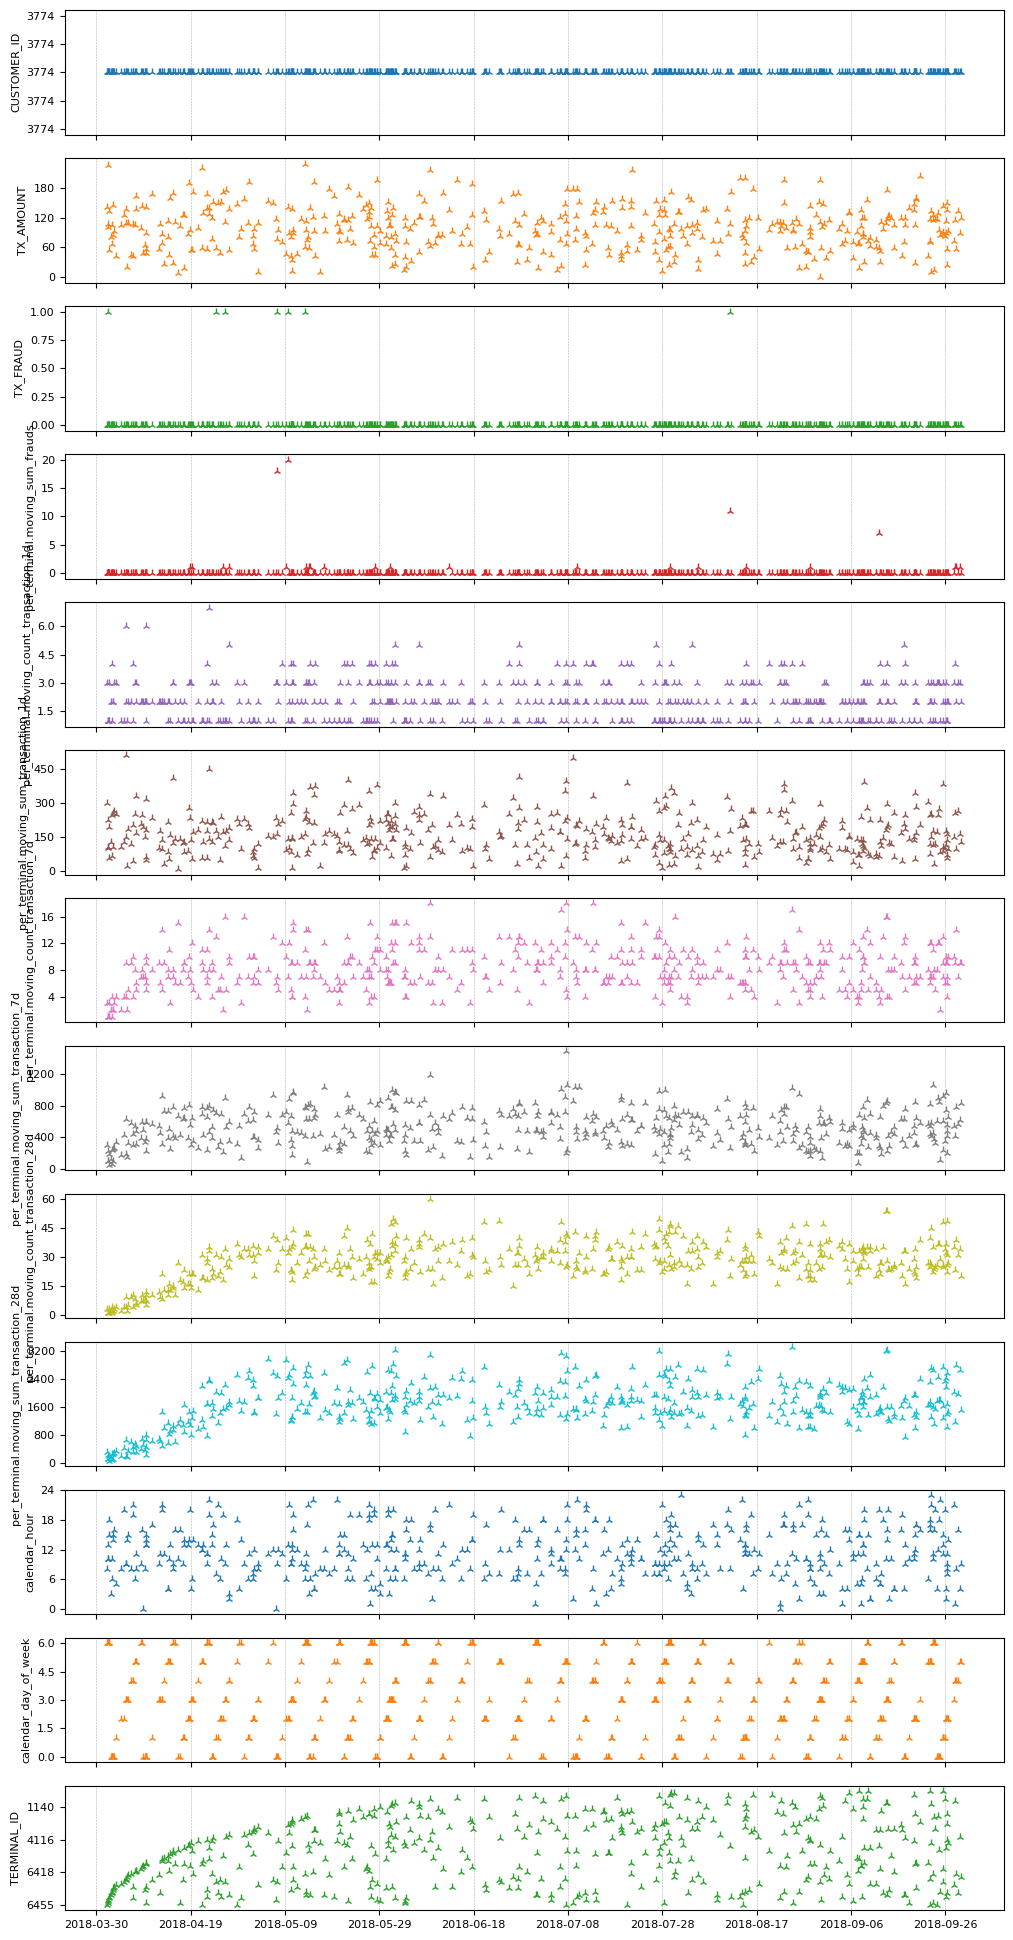

In [62]:
feature_transactions_es.filter(tp.equal(feature_transactions_es["CUSTOMER_ID"],"3774")).plot()

## Train and evaluate model

We split the dataset between training and testing, convert the Temporian EventSet back to a Pandas DataFrame, and train a YDF model.


In [63]:
is_train = feature_transactions_es.timestamps() < train_test_split.timestamp()
is_test = ~is_train

train_feature_transactions_es = feature_transactions_es.filter(is_train)
test_feature_transactions_es = feature_transactions_es.filter(is_test)

print(f"{train_feature_transactions_es.num_events()} training transactions")
print(f"{test_feature_transactions_es.num_events()} testing transactions")

1466091 training transactions
288064 testing transactions


In [64]:
train_ds_pd = tp.to_pandas(train_feature_transactions_es)
test_ds_pd = tp.to_pandas(test_feature_transactions_es)

print(f"{len(train_ds_pd)} training examples")
print(f"{len(test_ds_pd)} testing examples")

1466091 training examples
288064 testing examples


In [65]:
train_ds_pd

,CUSTOMER_ID,TX_AMOUNT,TX_FRAUD,per_terminal.moving_sum_frauds,per_terminal.moving_count_transaction_1d,per_terminal.moving_sum_transaction_1d,per_terminal.moving_count_transaction_7d,per_terminal.moving_sum_transaction_7d,per_terminal.moving_count_transaction_28d,per_terminal.moving_sum_transaction_28d,calendar_hour,calendar_day_of_week,TERMINAL_ID,timestamp
0,596,57.16,0,0,1,57.16,1,57.16,1,57.16,0,6,3156,1.522541e+09
1,4961,81.51,0,0,1,81.51,1,81.51,1,81.51,0,6,3412,1.522541e+09
2,2,146.00,0,0,1,146.00,1,146.00,1,146.00,0,6,1365,1.522541e+09
3,4128,64.49,0,0,1,64.49,1,64.49,1,64.49,0,6,8737,1.522541e+09
4,927,50.99,0,0,1,50.99,1,50.99,1,50.99,0,6,9906,1.522541e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466086,1321,79.06,0,0,2,123.09,8,342.55,26,941.59,21,4,229,1.535753e+09
1466087,4202,13.53,0,0,3,216.03,5,315.35,24,1233.40,21,4,5559,1.535753e+09
1466088,1879,19.64,0,0,1,19.64,7,274.47,26,1046.89,21,4,601,1.535753e+09
1466089,1864,73.29,0,0,4,192.22,13,598.69,25,1106.18,21,4,4571,1.535753e+09


In [66]:
learner = ydf.GradientBoostedTreesLearner(label="TX_FRAUD",
                                          features=["per_terminal.moving_sum_frauds",
                                                    "per_terminal.moving_count_transaction_1d",
                                                    "per_terminal.moving_count_transaction_7d",
                                                    "per_terminal.moving_count_transaction_28d",
                                                    "calendar_hour",
                                                    "calendar_day_of_week",
                                                    ],
                                          num_trees=100,  # Speed-up the training
                                          )
model = learner.train(train_ds_pd)

Train model on 1466091 examples
Model trained in 0:00:40.887605


We can evaluate the model on the test dataset.

In [67]:
model.evaluate(test_ds_pd)

Label \ Pred,0,1
0,284702,813
1,1770,779


## Understand model

Although the model does not operate on the raw transaction data directly, but rather on the preprocessed features, it can be interpreted. For example, examining the variable importance, we can see that the feature `per_terminal.moving_sum_frauds` is the most important to the model while the `calendar_day_of_week` does not matter much. We can interpret this as meaning that if a client has had past fraudulent transactions, it is a good indicator of future fraudulent transactions.

In [68]:
model.describe()

For example, if a client's card is stolen, we can look at the PDP model to see the relationship between the number of frauds in the last 4 weeks and the probability that a transaction is fraudulent.


In [69]:
model.analyze(test_ds_pd, sampling=0.1)